# Convolutional neural network framework

In [2]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pandas as pd
sns.set_style("darkgrid")



# Keras documentation can be found on keras.io:
import keras
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2024-06-03 16:01:50.280149: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 16:01:50.318227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 16:01:51.107685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Jens csv kode

In [4]:
def import_and_pad_csvs(folder_path):
    # List all CSV files in the given folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files_sorted = np.sort(np.array(csv_files))
    #print(csv_files_sorted)
    # Initialize an empty list to store the data arrays
    data_arrays = []

    indecies = np.zeros_like(csv_files_sorted, dtype=int)
    for i in range(len(csv_files_sorted)):
        indecies[i] = int(csv_files_sorted[i][:-6])
        #print(type(indecies[i]))
    #print(csv_files_sorted, indecies)
        
    
    # Iterate over the CSV files and read them into numpy arrays
    for file in csv_files_sorted:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path).values
        data_arrays.append(data)
    
    # Find the maximum number of rows and columns among all CSV files
    max_rows = max(array.shape[0] for array in data_arrays)
    max_cols = max(array.shape[1] for array in data_arrays)
    
    # Find the index of the largest array (by number of elements)
    largest_array_index = max(range(len(data_arrays)), key=lambda i: data_arrays[i].shape[0] * data_arrays[i].shape[1])
    
    print(f"Index of the largest initial array: {largest_array_index}")
    
    # Initialize a list to store padded arrays
    padded_arrays = np.zeros((max_rows, max_cols))
    center = max(int(max_rows / 2), int(max_cols / 2))
    max_size = 64
    combined_array = np.zeros((len(data_arrays), max_size, max_size))
    # Pad each array with zeros to match the maximum size
    nr = 0
    for array in data_arrays:
        #print(array.shape)
        #print(center - int(np.floor(array.shape[0] / 2)), center + int(np.ceil(array.shape[1] / 2)))
        padded_array = np.zeros((max_rows, max_cols)) + 4000
        #print(padded_array[center - int(np.floor(array.shape[0] / 2)) :center + int(np.ceil(array.shape[0]/2)),
                     #center - int(np.floor(array.shape[1] / 2)) :center + int(np.ceil(array.shape[1]/2))])
        padded_array[center - int(np.floor(array.shape[0] / 2)) :center + int(np.ceil(array.shape[0]/2)),
                     center - int(np.floor(array.shape[1] / 2)) :center + int(np.ceil(array.shape[1]/2))] = array
        combined_array[nr] = padded_array[center - int(max_size/2): center + int(max_size/2), center - int(max_size/2): center + int(max_size/2)]
        #combined_array = np.concatenate((combined_array, np.array([padded_arrays])), axis=0)
        #padded_arrays.append(padded_array)
        nr += 1
    

    # Stack all padded arrays along a new dimension to create the final array
    #combined_array = np.stack(padded_arrays, axis=0)
    
    
    return combined_array, indecies

# Import Data

In [5]:
a = np.array(['123456', '12345', '1235312'])



Index of the largest initial array: 3929
31 31


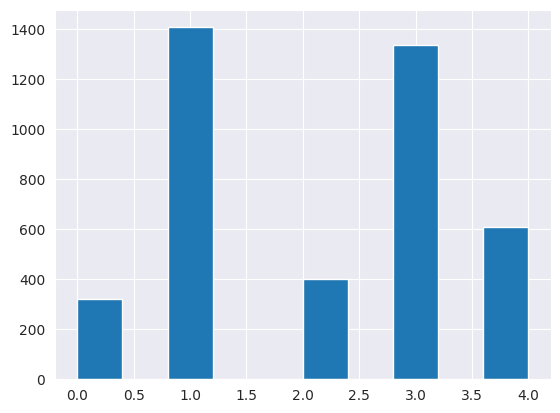

In [6]:
data_raw, index = import_and_pad_csvs('clusters_colour_rotations/')
labels_raw = [np.load('./labels/'+x) for x in os.listdir('./labels/') if x.endswith('.npy')]
print(len(labels_raw[8][0]), len(labels_raw[8][1]))

#labels_raw_sorted = np.sort(np.array(labels_raw))
label = []
ind = []
for value in labels_raw:
    label.append(value[1].tolist())
    ind.append(value[0].tolist())
    #print(len(value[1].tolist()), len(value[0].tolist()))
label = [item for sublist in label for item in sublist]
ind = [item for sublist in ind for item in sublist]
ind_sort_arg = np.argsort(np.repeat(ind, 8))
#mask = [index != ind]
#print(print(index, ind))
#plt.plot(index - ind)
#plt.show()

#index_remove = np.array([31, 74, 116, 165, 170, 193, 214, 280, 314, 401, 413, 470, 499])
#label = np.delete(label, index_remove)

label = np.repeat(label, 8)
#print(len(label)*8)
#print(data_raw.shape)

plt.hist(label)
plt.show()


label_sorted = label[ind_sort_arg]

# Remove all reading erros, multiple objects, and others.
data_raw = data_raw[(label_sorted != 4) & (label_sorted != 0)]
label_sorted = label_sorted[(label_sorted != 4) & (label_sorted != 0)] - 1

#print(data_raw.shape)
# the data, split between train and testval sets

### since the data is limited in amount, we will use crossvalidation to only have to split the data in train and test, and use the crossvalidation for the validation

train_images, testval_images, train_labels, testval_labels = train_test_split(data_raw, label_sorted, test_size=0.2, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(testval_images, testval_labels, test_size=0.5, random_state=13052020)



# Normelize Data

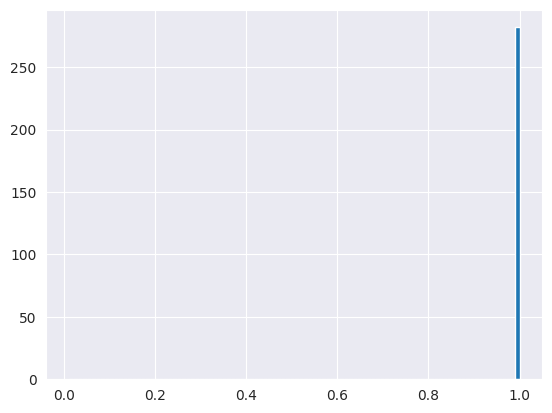

In [7]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, RobustScaler

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)


#scaler = MinMaxScaler()
#scaler = QuantileTransformer()
scaler = RobustScaler()
#sorted_images = np.sort(train_images.reshape(-1, 1))
#scaler.fit(sorted_images)
scaler.fit(train_images.reshape(-1, 1))
train_images = scaler.transform(train_images.reshape(-1, 1)).reshape(train_images.shape)
val_images = scaler.transform(val_images.reshape(-1, 1)).reshape(val_images.shape)
#test_images = scaler.transform(test_images.reshape(-1, 1)).reshape(test_images.shape)

plt.hist(train_images.flatten(), bins=100, range=(0.01, 1))
plt.show()
# Standardize pixel distribution to have zero mean and unit variance
#train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
#val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))
# Alternative: quantile normalization
# train_images = quantile_transform(train_images, output_distribution='normal', copy=True)
# val_images = quantile_transform(val_images, output_distribution='normal', copy=True)




# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 64, 64 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)
#test_images = val_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3 # number of classes
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
#test_labels = keras.utils.to_categorical(test_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
# test_images = quantile_transform(test_images, output_distribution='normal', copy=True)
#test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Setup CNN

In [13]:
def compile_CNN_model(model_type=Sequential(), layer_types=[Conv2D, MaxPooling2D, Flatten, Dropout, Dense], hyperperams_list=np.zeros((7,3)), img_rows=28, img_cols=28, num_classes=10):
    model = model_type  # Network model type

    N_layers = len(layer_types)
    layers = np.array([])
    for i in range(layer_types):
        if layer_types[i] == 0:
            layers = np.append(layers, Conv2D)
            hyp_peram = {'filters': hyperperams_list[i, 0], 'kernel_size': hyperperams_list[i, 1], 'strides': hyperperams_list[i, 2], 'activation': 'relu', 'input_shape': (img_rows, img_cols, 1)}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 1:
            layers = np.append(layers, MaxPooling2D)
            hyp_peram = {'pool_size': hyperperams_list[i, 0], 'strides': hyperperams_list[i, 1]}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 2:
            layers = np.append(layers, Flatten)
            hyp_peram = {}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 3:
            layers = np.append(layers, Dropout)
            hyp_peram = {'rate': hyperperams_list[i, 0]}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 4:
            layers = np.append(layers, Dense)
            hyp_peram = {'units': hyperperams_list[i, 0], 'activation': 'relu'}
            
    
    for i in range(N_layers):
        model.add(layers[i](**layer_hyperperams[i]))

    
    # specify optimization strategy and metric used for monitoring during training
    model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

    return model



model = Sequential()  # Network type is Sequential

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])


def create_tf_model_CNN(trial):
    N_conv_layers = trial.suggest_int('N_conv_layers', 1, 3)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log=True)
    N_dense_layers = trial.suggest_int('N_dense_layers', 1, 3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    model = Sequential()  # Network type is Sequential
    for i in range(N_conv_layers):
        model.add(Conv2D(filters=2**trial.suggest_int('conv_filter_exp'+str(i), 4, 8),
                         kernel_size=3,
                         strides=1,
                         padding='same',
                         activation='relu',
                         input_shape=(img_rows, img_cols, 1)))
        model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    for i in range(N_dense_layers - 1):
        model.add(Dense(units=2**trial.suggest_int('dense_units_exp'+str(i), 4, 8), activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.summary()
    return model

def create_tf_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def objective(trial, X_train, Y_train, X_test, Y_test):
    # Build model and optimizer.
    model = create_tf_model_CNN(trial)
    optimizer = create_tf_optimizer(trial)
    model.compile(optimizer, loss=categorical_crossentropy)
    # Fit the model to the data
    model.fit(x=X_train, y = Y_train, epochs=10, validation_data=(X_test, Y_test), verbose=0)
    # Find the accuracy
    accuracy = categorical_crossentropy(Y_test, model(X_test))
    # Return accuracy
    return accuracy






/home/sk0rt3/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,483 (8.07 MB)

 Trainable params: 2,116,483 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

## HYPER OPT der virker

In [14]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_images, train_labels, val_images, val_labels), n_trials=2)
trial = study.best_trial



[I 2024-06-03 16:05:13,700] A new study created in memory with name: no-name-35759d15-17ce-4d1f-a8ae-4ea31570e4e8
/tmp/ipykernel_233137/3826980487.py:80: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3, log=True)
[W 2024-06-03 16:05:13,702] Trial 0 failed with parameters: {'N_conv_layers': 1} because of the following error: TypeError("Trial.suggest_loguniform() got an unexpected keyword argument 'log'").
Traceback (most recent call last):
  File "/home/sk0rt3/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_233137/3829621522.py", line 3, in <lambda>
    study.optimize(lambda trial: objective(trial, train_images, train_labels, val_im

TypeError: Trial.suggest_loguniform() got an unexpected keyword argument 'log'

In [ ]:
tf_model = create_tf_model_CNN(trial)
tf_optimizer = create_tf_optimizer(trial)
tf_model.compile(optimizer=tf_optimizer, loss=categorical_crossentropy, metrics=['categorical_accuracy'])
tf_model.fit(x=train_images, y=train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=1)

# Train CNN

In [147]:
# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=256,
                    epochs=5000,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - categorical_accuracy: 0.3194 - loss: 191.0000 - val_categorical_accuracy: 0.2166 - val_loss: 120.4567
Epoch 2/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - categorical_accuracy: 0.3416 - loss: 177.2306 - val_categorical_accuracy: 0.2484 - val_loss: 106.3861
Epoch 3/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.3534 - loss: 171.0882 - val_categorical_accuracy: 0.2803 - val_loss: 94.4242
Epoch 4/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.3920 - loss: 157.8262 - val_categorical_accuracy: 0.3344 - val_loss: 84.9637
Epoch 5/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.4172 - loss: 141.4201 - val_categorical_accuracy: 0.4140 - val_loss: 77.1096
Epoch 6/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - categorical_accuracy: 0.3987 - loss: 142.4125 - val_categorical_accuracy: 0.4777 - val_loss: 70.7760
Epoch 7/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - 

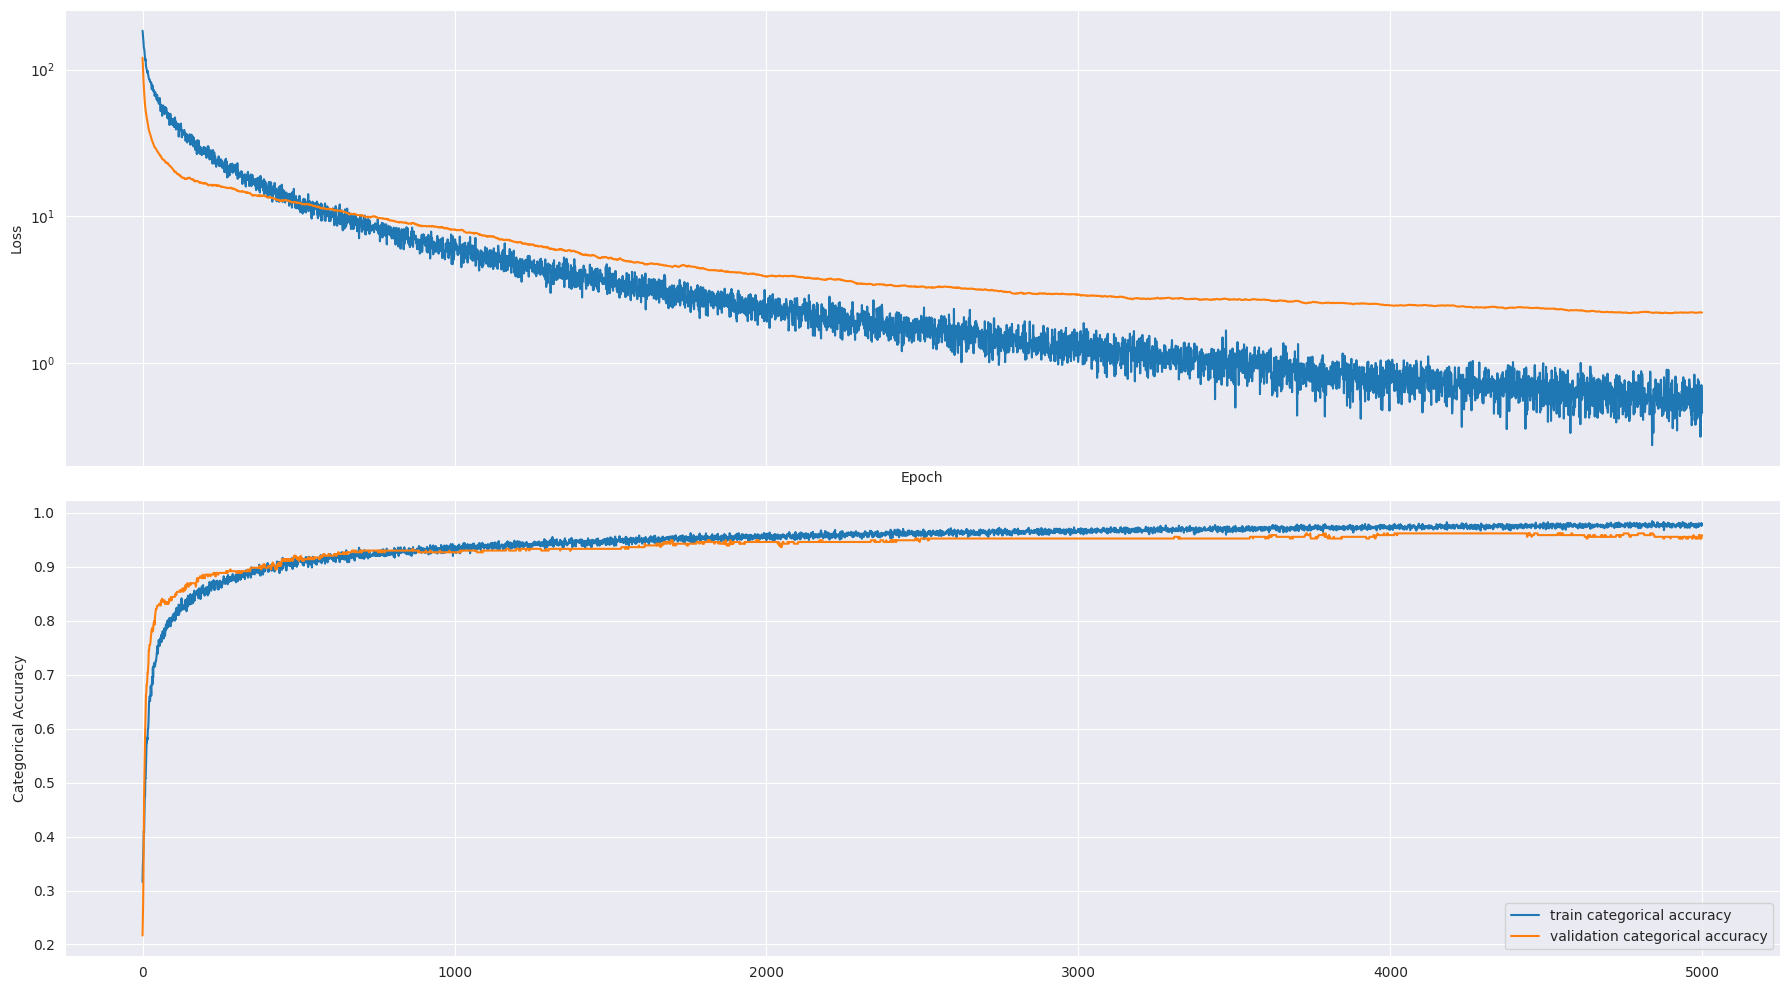

In [156]:
fig, ax = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches((18, 10))
ax[0].set_yscale('log')
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[1].plot(history.history['categorical_accuracy'], label='train categorical accuracy')
ax[1].plot(history.history['val_categorical_accuracy'], label='validation categorical accuracy')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Categorical Accuracy')
fig.tight_layout()
plt.legend()
plt.show()

# Save the model

In [158]:
model.save_weights('categorical_CNN_2_6.weights.h5')

# Hyperperameter optimization

In [ ]:
import optuna


def objective(trial):
    layer_numbers = trial.suggest_int('layer_numbers', 1, 10)
    peram = {'model_type': Sequential(),
                'layer_types': [trail.sugeest_int('layer_types', 0, 4, layer_numbers) for i in range(layer_numbers)],
                'hyperperams_list': np.zeros((7,3)),
                'img_rows': 28,
                'img_cols': 28,
                'num_classes': 10
                }
        
    

def objective_exmaple(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1),
        'objective': 'binary:logistic'
    }
    bst = XGBClassifier(**param)
    bst.fit(df_train_X_clf_final, df_train_Y_clf_final)
    preds = bst.predict_proba(df_valid_X_clf_final)
    log_log_clf_XGB = log_loss(df_valid_Y_clf_final, preds)
    return log_log_clf_XGB

study_example = optuna.create_study(direction='minimize')
study_example.optimize(objective_example, n_trials=20, show_progress_bar=True)